In [1]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

# Create output folder
import os
#output_folder = "recommendations"
output_folder = "data/daily"

os.makedirs(output_folder, exist_ok=True)

In [2]:
# URLs
URL_GAINERS = "https://query1.finance.yahoo.com/v1/finance/screener/predefined/saved?scrIds=day_gainers&count=250"
URL_ACTIVE = "https://query1.finance.yahoo.com/v1/finance/screener/predefined/saved?scrIds=most_actives&count=250"
URL_TRENDING = "https://query1.finance.yahoo.com/v1/finance/screener/predefined/saved?scrIds=trending_tickers&count=250"

In [3]:
def fetch_screener(scrId, count=250): 
    url = f"https://query1.finance.yahoo.com/v1/finance/screener/predefined/saved?scrIds={scrId}&count={count}"
    try:
        r = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})
        data = r.json()["finance"]["result"][0]["quotes"]
        return pd.DataFrame(data)
    except Exception as e:
        print(f"Error loading screener {scrId}: {e}")


In [4]:
def fetch_trending():
    url = "https://query1.finance.yahoo.com/v1/finance/trending/US"
    try:
        r = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})
        data = r.json()["finance"]["result"][0]["quotes"]
        return pd.DataFrame(data)
    except Exception as e:
        print(f"Error loading trending {e}")

In [5]:
import re

def filter_equities(df):
    eq = []
    for s in df["symbol"]:
        if re.fullmatch(r"[A-Za-z][A-Za-z0-9\.-]{0,9}", s):
            eq.append(s)
    return pd.DataFrame({"symbol": eq})


In [6]:
print("Downloading Yahoo lists...")

df_gainers = fetch_screener("day_gainers")
df_active  = fetch_screener("most_actives")
df_trending_raw = fetch_trending()
df_trending = filter_equities(df_trending_raw)


print("Gainers:", len(df_gainers))
print("Most Active:", len(df_active))
print("Trending:", len(df_trending))

combined = pd.concat([df_gainers, df_active, df_trending], ignore_index=True)
combined.drop_duplicates(subset="symbol", inplace=True)

print("Total unique hot symbols:", len(combined))


Gainers: 98
Most Active: 250
Trending: 20
Total unique hot symbols: 328


In [7]:
def fix_num(x):
    """
    Convert Yahoo formatted numbers:
    '1.2M', '330K', '2.3B' → float
    """
    if x is None:
        return np.nan
    if isinstance(x, (int, float)):
        return float(x)

    x = str(x).replace(",", "")

    try:
        if x.endswith("M"):
            return float(x[:-1]) * 1e6
        if x.endswith("B"):
            return float(x[:-1]) * 1e9
        if x.endswith("K"):
            return float(x[:-1]) * 1e3
        return float(x)
    except:
        return np.nan

numeric_cols = [
    "regularMarketPrice",
    "regularMarketChangePercent",
    "regularMarketChange",
    "regularMarketVolume",
    "averageDailyVolume3Month",
    "marketCap"
]

for col in numeric_cols:
    if col in combined.columns:
        combined[col] = combined[col].apply(fix_num)

In [8]:
df = combined.copy()

# Volume Spike Score
df["VolumeSpike"] = df["regularMarketVolume"] / df["averageDailyVolume3Month"]
df["VolumeScore"] = df["VolumeSpike"].rank(pct=True)

# Momentum Score (based on daily % change)
df["MomentumScore"] = df["regularMarketChangePercent"].rank(pct=True)

# Volatility Score (higher movement = more hot)
df["VolatilityScore"] = df["regularMarketChange"].abs().rank(pct=True)

# Trend Score (proxy: price vs avg volume)
df["TrendScore"] = (df["regularMarketPrice"] / (df["averageDailyVolume3Month"] + 1)).rank(pct=True)

# Final score
df["HotScore"] = (
    0.35 * df["MomentumScore"] +
    0.35 * df["VolumeScore"] +
    0.20 * df["VolatilityScore"] +
    0.10 * df["TrendScore"]
)

df.sort_values("HotScore", ascending=False, inplace=True)

# Keep relevant columns
output_df = df[[
    "symbol",
    "regularMarketPrice",
    "regularMarketChangePercent",
    "regularMarketVolume",
    "averageDailyVolume3Month",
    "marketCap",
    "VolumeSpike",
    "MomentumScore",
    "VolumeScore",
    "VolatilityScore",
    "TrendScore",
    "HotScore"
]]

In [9]:
top50 = output_df.head(50)


timestamp = datetime.now().strftime("%Y%m%d%H%M%S") 
file_path = os.path.join(output_folder, f"hot_stocks_{timestamp}.csv")
top50.to_csv(file_path, index=False)

print("\n🔥 Saved TOP 50 hot stocks to:", file_path)
top50



🔥 Saved TOP 50 hot stocks to: data/daily\hot_stocks_20251118220120.csv


,symbol,regularMarketPrice,regularMarketChangePercent,regularMarketVolume,averageDailyVolume3Month,marketCap,VolumeSpike,MomentumScore,VolumeScore,VolatilityScore,TrendScore,HotScore
14,JAZZ,180.520,6.132052,4146122.0,825357.0,1.096932e+10,5.023429,0.952978,0.990596,0.974922,0.981191,0.973354
18,BLTE,123.190,5.371652,136035.0,67032.0,4.298222e+09,2.029404,0.931034,0.940439,0.940439,1.000000,0.943103
1,DGNX,16.200,19.205301,2847189.0,767879.0,3.288687e+09,3.707862,0.996865,0.981191,0.836991,0.821317,0.941850
15,MSTR,206.800,5.823358,20900158.0,12046590.0,5.942475e+10,1.734944,0.946708,0.899687,0.981191,0.789969,0.921473
31,MDT,100.830,4.725803,19767560.0,6931262.0,1.293262e+11,2.851942,0.905956,0.971787,0.912226,0.771160,0.916771
5,AS,33.350,8.420020,12960572.0,5230676.0,1.849496e+10,2.477801,0.981191,0.956113,0.833856,0.620690,0.906897
8,TERN,27.560,7.824727,5309687.0,2393689.0,2.482599e+09,2.218203,0.978056,0.946708,0.789969,0.730408,0.904702
57,NTRA,213.650,3.693458,2116335.0,1172681.0,2.948679e+10,1.804698,0.830721,0.912226,0.952978,0.978056,0.898433
23,GLBE,37.010,5.351543,2742047.0,1367673.0,6.281562e+09,2.004900,0.927900,0.934169,0.780564,0.865204,0.894357
27,TIGO,56.100,4.801046,1577183.0,915517.0,9.373468e+09,1.722724,0.912226,0.896552,0.830721,0.927900,0.892006


In [10]:
top50['symbol']

14     JAZZ
18     BLTE
1      DGNX
15     MSTR
31      MDT
5        AS
8      TERN
57     NTRA
23     GLBE
27     TIGO
2       LGN
4      SRRK
11     LQDA
28     CHDN
38      MRK
24     NBIS
81      MOH
70     BFAM
0      ONDS
39      TFX
9       JHX
50     EXAS
21     UPWK
52     HTFL
26     LSCC
37     ARQT
95     PCAR
79     TMDX
30     CWAN
44     CNTA
45      VLO
90     REGN
12       MH
10     QUBT
84     WAFD
42     WRBY
49      CLH
67     NFLX
126     LNW
222    BRBR
323    BIDU
6      WULF
22     MSGE
46     TARS
63      ALB
73       BL
43     DECK
56       SM
60     XMTR
93      GFL
Name: symbol, dtype: object

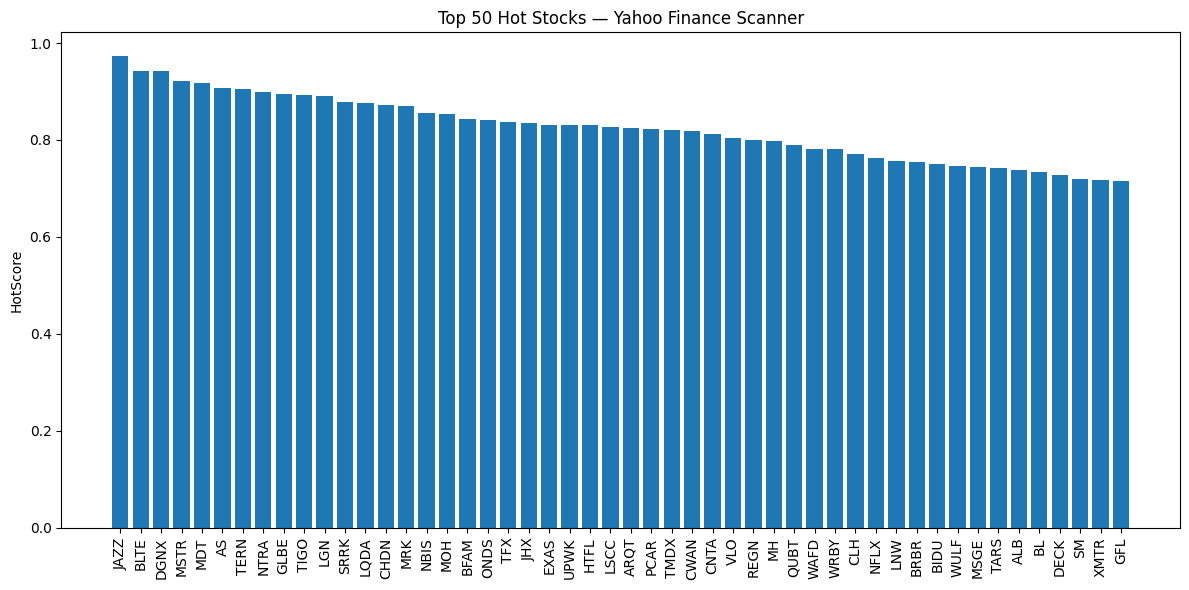

In [11]:

# --------------------------------------------------------
# 6. Plot Heat Bar
# --------------------------------------------------------

plt.figure(figsize=(12, 6))
plt.bar(top50["symbol"], top50["HotScore"])
plt.xticks(rotation=90)
plt.title("Top 50 Hot Stocks — Yahoo Finance Scanner")
plt.ylabel("HotScore")
plt.tight_layout()
plt.show()